In [1]:
import io
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression 

###########################################################################
#generate training/test data
########################################################################### 
bragging_file = io.open("Happy_clean.txt",'r',encoding="utf-8") 
bitching_file = io.open("FML_clean.txt",'r',encoding="utf-8") 

training_samples = 30000
bragging_tweets = []
bitching_tweets = []

for _ in range(249000):
    bragging_tweets.append([bragging_file.readline().strip("\n"),0])
    bitching_tweets.append([bitching_file.readline().strip("\n"),1])
    
tweets = bragging_tweets+bitching_tweets
np.random.seed(42)
np.random.shuffle(tweets)


tweets_train = np.array(tweets[:348600])
tweets_test = np.array(tweets[348600:498000])

X_train = tweets_train[:,0]
Y_train = tweets_train[:,1]
# X_val = tweets_train[training_samples:maximum_data,0]
# Y_val = tweets_train[training_samples:maximum_data,1]
X_test = tweets_test[:,0]
Y_test = tweets_test[:,1]

# #########################################################################
# #bag of words
# #########################################################################

# vectorizer = CountVectorizer()
# X_train_counts = vectorizer.fit_transform(X_train)
# X_val_counts = vectorizer.transform(X_val)
# X_test_counts = vectorizer.transform(X_test)


# # tfidf_transformer = TfidfTransformer()
# # X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# # X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# #########################################################################
# #logistic regression
# #########################################################################

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50
training_samples = 200000
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print ('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 271907 unique tokens.


In [3]:
data = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(Y_train)
print ("shape of the data tensor:", data.shape)
print ("shape of the label tensor: ", labels.shape)

shape of the data tensor: (348600, 50)
shape of the label tensor:  (348600,)


In [4]:
# splits data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
import os

x_train = data[:]
y_train = labels[:]
# x_val = data[training_samples:]
# y_val = labels[training_samples:]

glove_dir = '/Users/hamzakhan/Desktop/Winter 2018/Hashtag_Recommendations_NN/glove.twitter.27B'
embeddings_index = {}
#your maxlen and you .txt files must correspond
f = open(os.path.join(glove_dir, 'glove.twitter.27B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs=np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 1193514 word vectors.


In [5]:
embedding_dim = maxlen
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if (i < max_words):
        embedding_vector= embeddings_index.get(word)
        if (embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
            

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 580,065
Trainable params: 580,065
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [8]:
import keras.optimizers
sgd = keras.optimizers.SGD(lr=0.0001*400)
model.compile(optimizer = sgd,
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(x_train, y_train, epochs = 10, batch_size= 32, validation_split = 0.05 )
model.save_weights('pre-trained_glove_twitter_model.h5')

Train on 331170 samples, validate on 17430 samples
Epoch 1/10
331170/331170 [==============================] - 32s 96us/step - loss: 0.2929 - acc: 0.8774 - val_loss: 0.3924 - val_acc: 0.8301
Epoch 2/10
331170/331170 [==============================] - 33s 99us/step - loss: 0.2634 - acc: 0.8908 - val_loss: 0.2687 - val_acc: 0.8901
Epoch 3/10
331170/331170 [==============================] - 35s 106us/step - loss: 0.2537 - acc: 0.8954 - val_loss: 0.2704 - val_acc: 0.8893
Epoch 4/10
331170/331170 [==============================] - 31s 92us/step - loss: 0.2468 - acc: 0.8985 - val_loss: 0.2525 - val_acc: 0.8974
Epoch 5/10
331170/331170 [==============================] - 34s 103us/step - loss: 0.2414 - acc: 0.9005 - val_loss: 0.2532 - val_acc: 0.8985
Epoch 6/10
331170/331170 [==============================] - 35s 106us/step - loss: 0.2368 - acc: 0.9023 - val_loss: 0.2481 - val_acc: 0.8980
Epoch 7/10
331170/331170 [==============================] - 34s 103us/step - loss: 0.2328 - acc: 0.9040 - 

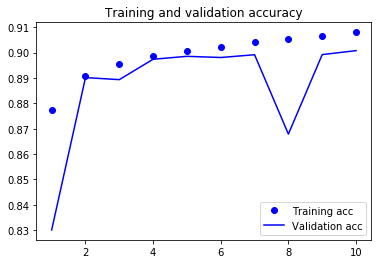

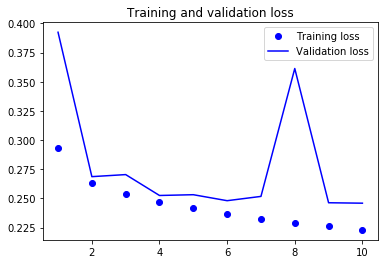

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
## These will be results on the test
sequences = tokenizer.texts_to_sequences(X_test)
x_test = pad_sequences(sequences, maxlen = maxlen)
y_test = np.asarray(Y_test)
model.load_weights('pre-trained_glove_twitter_model.h5')
model.evaluate(x_test, y_test)

149400/149400 [==============================] - 6s 41us/step


[0.24519523541691154, 0.90046854083317829]